# Sample Size and Effective Power Calculations

Resources:

* [Power analysis with psych python](http://www.djmannion.net/psych_programming/data/power/power.html)
* [Power Analysis and power curves with statsmodels](https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/)

## Calculating power given effect size and sample size

We will begin by considering a scenario in which we have an effect size and sample size in mind and we would like to know the associated power. For our example experiment, we will use a between-subjects design with two factors, 30 participants per group, and we will assume a ‘large’ effect size (Cohen’s d = 0.8). You might recognise this design, as it was the same that we used in the previous lesson to demonstrate the operation of the independent-samples t-test. Here, we will determine the power of this test.

The key to determining power using a simulation approach is to again leverage the computational capacity that we have once we are able to write our own programs. We will perform a large number of simulated experiments, each time calculating our test statistic (independent samples t-test, in this case) and accumulating the number of times we reject the null hypothesis. Then, the power is simply the proportion of times that we are able to reject the null hypothesis (remembering that we control the population means and we know that there is a true difference).

In [0]:
# !sudo apt-get install -y -qq veusz

In [0]:
import numpy as np
from scipy.stats import ttest_ind as t_test
# import veusz.embed
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [0]:
n_per_group = 30

# effect size or Cohen's d = 0.8
cohens_d_effect_size = 0.8
group_means = [0.0, cohens_d_effect_size]
group_sigmas = [1.0, 1.0]

n_groups = len(group_means)

# number of simulations
n_sims = 10000

# store the p value for each simulation
sim_p = np.empty(n_sims)
sim_p.fill(np.nan)

for i_sim in range(n_sims):

    data = np.empty([n_per_group, n_groups])
    data.fill(np.nan)

    # simulate the data for this 'experiment'
    for i_group in range(n_groups):

        data[:, i_group] = np.random.normal(
            loc=group_means[i_group],
            scale=group_sigmas[i_group],
            size=n_per_group
        )

    result = t_test(data[:, 0], data[:, 1])

    sim_p[i_sim] = result[1]

# number of simulations where the null was rejected
n_rej = np.sum(sim_p < 0.05)

prop_rej = n_rej / float(n_sims)

print(f"Power:{prop_rej}")

Power:0.8656


# Required sample size to achieve a given power for a given effect size

Now we will move on to a more common scenario, where you have a design and effect size in mind and would like to know what sample size you would need to achieve a particular power (80% is typical). This is a straightforward extension of the previous example: we begin with a sample size and calculate the associated power. We then perform such a calculation repeatedly, each time increasing the sample size, until the power has reached the desired level.

In [0]:
def sample_size_calculator(mu, sigma, n_per_group=20, desired_power=0.8, n_simulations=10000):
    """
    :params mu: list or array of means for n groups
    :params sigma: list or array of standard deviation for n groups
    """
    n_groups = len(mu)
    sample_sizes = []
    powers = []
    # initialise the power for the current sample size to a small value
    current_power = 0.0

    # keep iterating until desired power is obtained
    while current_power < desired_power:

        data = np.empty([n_sims, n_per_group, n_groups])
        data.fill(np.nan)

        for i_group in range(n_groups):

            data[:, :, i_group] = np.random.normal(
                loc=mu[i_group],
                scale=sigma[i_group],
                size=[n_sims, n_per_group]
            )

        result = t_test(
            data[:, :, 0],
            data[:, :, 1],
            axis=1
        )

        sim_p = result[1]

        # number of simulations where the null was rejected
        n_rej = np.sum(sim_p < 0.05)

        prop_rej = n_rej / float(n_sims)

        current_power = prop_rej

        sample_sizes.append(n_per_group)
        powers.append(current_power)

        # print("With {n:d} samples per group, power = {p:.3f}".format(
        #     n=n_per_group,
        #     p=current_power
        # ))

        # increase the number of samples by one for the next iteration of the loop
        n_per_group += 1
    
    required_sample_size = sample_sizes[-1]
    required_power = powers[-1]

    return required_sample_size, required_power

In [0]:
group_means = [0.0, 0.8]
group_sigmas = [1.0, 2.0]
required_sample_size, required_power = sample_size_calculator(group_means, group_sigmas, n_per_group=20, desired_power=0.97, n_simulations=10000)
print(f"Required sample size: {required_sample_size} for specified statistical power of: {required_power}")

Required sample size: 117 for specified statistical power of: 0.9736


# Visualising the sample size/power relationship

In the previous example, we sought to determine the sample size that would provide a given level of power. However, perhaps we do not have a single level of power in mind at the moment but would like to see the relationship between sample size and power so that we can see the costs and benefits of a particular sample size.

First, we will use a similar approach to the previous example, however we will perform the simulations across a fixed set of sample sizes. We will then save the power values to disk so that we can use them to create a visualisation without having to re-run all the simulations.

In [0]:
# let's look at samples sizes of 10 per group up to 50 per group in steps of 5
ns_per_group = np.arange(10, 51, 5)

# a bit awkward - number of n's
n_ns = len(ns_per_group)

# effect size = 0.8
group_means = [0.0, 0.8]
group_sigmas = [1.0, 1.0]

n_groups = len(group_means)

# number of simulations
n_sims = 10000

power = np.empty(n_ns)
power.fill(np.nan)

for i_n in range(n_ns):

    n_per_group = ns_per_group[i_n]

    data = np.empty([n_sims, n_per_group, n_groups])
    data.fill(np.nan)

    for i_group in range(n_groups):

        data[:, :, i_group] = np.random.normal(
            loc=group_means[i_group],
            scale=group_sigmas[i_group],
            size=[n_sims, n_per_group]
        )

    result = t_test(
        data[:, :, 0],
        data[:, :, 1],
        axis=1
    )

    sim_p = result[1]

    # number of simulations where the null was rejected
    n_rej = np.sum(sim_p < 0.05)

    prop_rej = n_rej / float(n_sims)

    power[i_n] = prop_rej

# this is a bit tricky
# what we want to save is an array with 2 columns, but we have 2 different 1D
# arrays. here, we use the 'np.newaxis' property to add a column each of the
# two 1D arrays, and then 'stack' them horizontally
array_to_save = np.hstack(
    [
        ns_per_group[:, np.newaxis],
        power[:, np.newaxis]
    ]
)

power_path = "prog_data_vis_power_sim_data.tsv"

np.savetxt(
    power_path,
    array_to_save,
    delimiter="\t",
    header="Simulated power as a function of samples per group"
)

Now, we want to begin our visualisation code by loading the data we just saved.

In [0]:
power = np.loadtxt(power_path, delimiter="\t")

# number of n's is the number of rows
n_ns = power.shape[0]

ns_per_group = power[:, 0]
power_per_ns = power[:, 1]

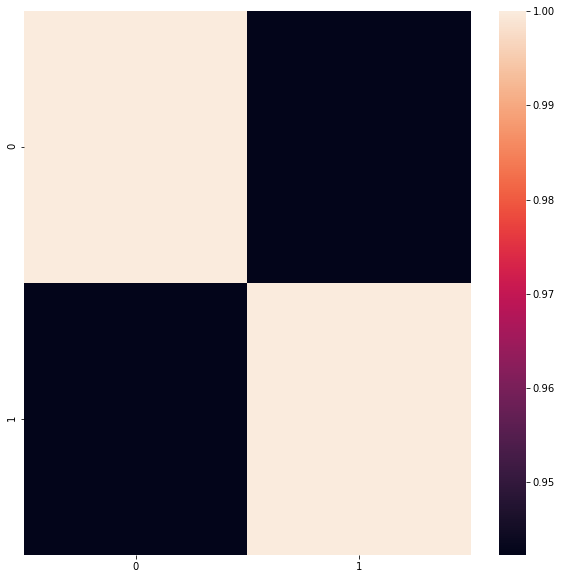

In [0]:
import pandas as pd

fig, ax = plt.subplots(figsize=(10, 10))
corr = pd.DataFrame(power).corr()
sns.heatmap(corr, annot=False, ax=ax)
plt.show()

In [0]:
power_path = "prog_data_vis_power_sim_data.tsv"

power = np.loadtxt(power_path, delimiter="\t")

# number of n's is the number of rows
n_ns = power.shape[0]

ns_per_group = power[:, 0]
power_per_ns = power[:, 1]

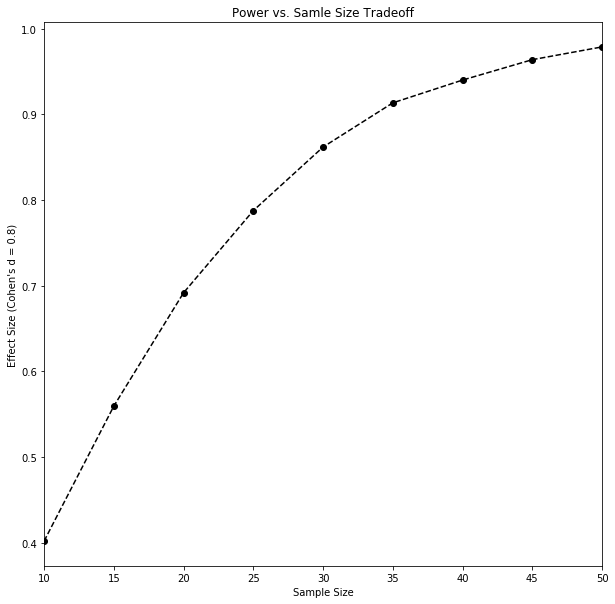

In [0]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.title("Power vs. Samle Size Tradeoff")
plt.xlabel("Sample Size")
plt.ylabel("Effect Size (Cohen's d = 0.8)")
plt.plot(ns_per_group, power_per_ns, marker="o", linestyle="--", c="k")
plt.xlim(min(ns_per_group), max(ns_per_group))
plt.show()

# Calculating power across varying sample and effect sizes

In the previous examples, we have assumed a fixed (‘large’) effect size. However, perhaps we want to investigate how power changes with both effect size and sample size. This is again a straightforward extension of the previous example. We will again save the data to disk to facilitate subsequent visualisation.

In [0]:
# let's look at samples sizes of 10 per group up to 50 per group in steps of 5
ns_per_group = np.arange(10, 51, 5)

# a bit awkward - number of n's
n_ns = len(ns_per_group)

# span the range from a bit less than a 'small' effect size to a bit bigger
# than a 'large' effect size
effect_sizes = np.arange(0.2, 0.91, 0.1)

n_effect_sizes = len(effect_sizes)

power = np.empty([n_effect_sizes, n_ns])
power.fill(np.nan)

# number of simulations
n_sims = 10000

for i_es in range(n_effect_sizes):

    group_means = [0.0, effect_sizes[i_es]]
    group_sigmas = [1.0, 1.0]

    n_groups = len(group_means)

    for i_n in range(n_ns):

        n_per_group = ns_per_group[i_n]

        data = np.empty([n_sims, n_per_group, n_groups])
        data.fill(np.nan)

        for i_group in range(n_groups):

            data[:, :, i_group] = np.random.normal(
                loc=group_means[i_group],
                scale=group_sigmas[i_group],
                size=[n_sims, n_per_group]
            )

        result = t_test(
            data[:, :, 0],
            data[:, :, 1],
            axis=1
        )

        sim_p = result[1]

        # number of simulations where the null was rejected
        n_rej = np.sum(sim_p < 0.05)

        prop_rej = n_rej / float(n_sims)

        power[i_es, i_n] = prop_rej

power_path = "prog_data_vis_power_es_x_ss_sim_data.tsv"

np.savetxt(
    power_path,
    power,
    delimiter="\t",
    header="Simulated power as a function of samples per group and ES"
)

In [0]:
power_path = "prog_data_vis_power_es_x_ss_sim_data.tsv"

power = np.loadtxt(power_path, delimiter="\t")

# number of effect sizes is the number of rows
n_effect_sizes = power.shape[0]
# number of n's is the number of columns
n_ns = power.shape[1]

ns_per_group = np.arange(15, 51, 5)
effect_sizes = np.arange(0.2, 0.91, 0.1)

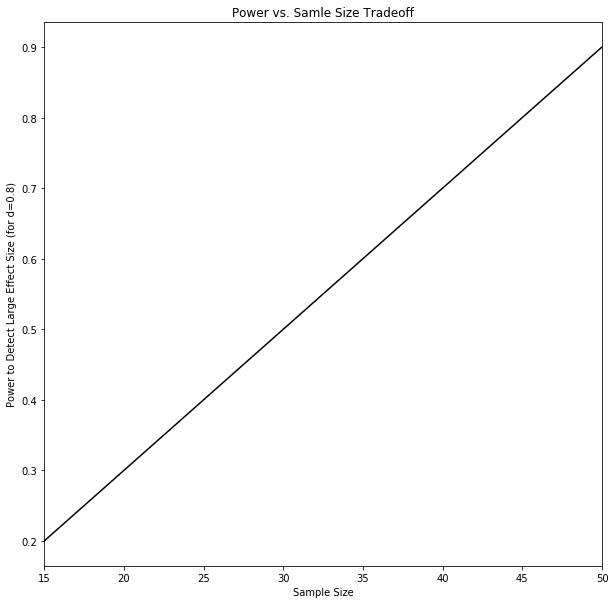

In [0]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.title("Power vs. Samle Size Tradeoff")
plt.xlabel("Sample Size")
plt.ylabel("Power to Detect Large Effect Size (for d=0.8)")
plt.plot(ns_per_group, effect_sizes, c="k")
plt.xlim(min(ns_per_group), max(ns_per_group))
plt.show()

# Power Analysis

You can perform power analysis (i.e., discovering one of the 4 elements required of a power analysis - Effect size, signficance, statistical power, and sample size) with thestatsmodels.stats.power.TTestIndPower class. This class has methods such as ```.plot_power(), .solve_power()``` and ```.power()```.

Using some of the data above, let's use  this class to perform a power calculation to determine the required sample sizes for our experiment given these power parameters:

* Effect size Cohen's d = 0.8 (the standardized number of deviations a sample mean is different from the other group mean)
* Significance level, or allowed 5% chance to raise a flag for a false detection of an effect when in reality there is no effect = 0.05
* Power (Beta, which is the probability of detecting the effect given that there truly is an effect existing) = 0.8 or 80%
* sample size (nobs1) = None (which is what was want the ```..solve_power()```. method to solve

In [5]:
# estimate sample size via power analysis

from statsmodels.stats.power import TTestIndPower
# parameters for power analysis
cohens_d_effect_size = 0.8
significance = 0.05
power = 0.8
# perform power analysis

analysis = TTestIndPower()
result = analysis.solve_power(cohens_d_effect_size, power=power, nobs1=None, ratio=1.0, alpha=significance)
print(f'Sample Size: {result:.3f}')

Sample Size: 25.525


## Plotting the power curves with statsmodels

Power curves are line plots that show how the change in variables, such as effect size and sample size, impact the power of the statistical test.

The plot_power() function can be used to create power curves. The dependent variable (x-axis) must be specified by name in the ‘dep_var‘ argument. Arrays of values can then be specified for the sample size (nobs), effect size (effect_size), and significance (alpha) parameters. One or multiple curves will then be plotted showing the impact on statistical power.

For example, we can assume a significance of 0.05 (the default for the function) and explore the change in sample size between 5 and 100 with low, medium, and high effect sizes.

Text(0, 0.5, "Effect Size (Cohen's d)")

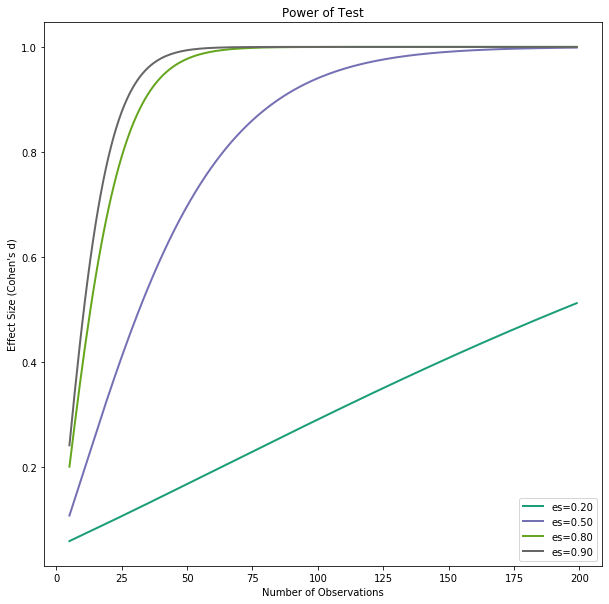

In [33]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 10))

sample_sizes = np.arange(5, 200)
effect_sizes = np.array([0.2, 0.5, 0.8, 0.9])

power_plot = TTestIndPower().plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes, ax=ax)
ax.set_ylabel("Effect Size (Cohen's d)")
plt.show()

Usefully, statsmodels has [classes to perform a power analysis](http://www.statsmodels.org/dev/stats.html#power-and-sample-size-calculations) with other statistical tests, such as the F-test, Z-test, and the Chi-Squared test.